# LeNet-5
## Gradient-Based Learning Applied to Document Recognition (1998)

This notebook contains implementation of the **LeNet-5** Convolutional Neural Network in **PyTorch** where custom or older approaches were substituted by modern techniques.

Original paper: http://vision.stanford.edu/cs598_spring07/papers/Lecun98.pdf

### Architecture
![image.png](https://www.datasciencecentral.com/wp-content/uploads/2021/10/1lvvWF48t7cyRWqct13eU0w.jpeg)

### Architecture details
* Input Layer:
 > "The input is a 32x32 pixel image. This is significantly larger than the largest character in the database (at most 20x20 pixels centered in a 28x28 field). The reason is that it is desirable that potential distinctive features such as stroke endpoints or corner can appear in the center of the receptive field of the highest-level feature detectors. In LeNet-5, the set of centers of the receptive fields of the last convolutional layer (C5, see below) form a 20x20 area in the center of the 32x32 input. The values of the input pixels are normalized so that the background level (white) corresponds to a value of -0.1 and the foreground (black) corresponds to 1.175. This makes the mean input roughly 0 and the variance roughly 1, which accelerates learning"

* Layer C1 (First Convolutional):
 > "Layer C1 is a convolutional layer with 6 feature maps. Each unit in each feature map is connected to a 5x5 neighborhood in the input. The size of the feature maps is 28x28 which prevents connection from the input from falling off the boundary. C1 contains 156 trainable parameters and 122,304 connections"

* Layer S2 (First Subsampling):
 > "Layer S2 is a sub-sampling layer with 6 feature maps of size 14x14. Each unit in each feature map is connected to a 2x2 neighborhood in the corresponding feature map in C1. The four inputs to a unit in S2 are added, then multiplied by a trainable coefficient, and added to a trainable bias. The result is passed through a sigmoidal function. The 2x2 receptive fields are non-overlapping, therefore feature maps in S2 have half the number of rows and column as feature maps in C1. Layer S2 has 12 trainable parameters and 5,880 connections"

* Layer C3 (Second Convolutional):
 > "Layer C3 is a convolutional layer with 16 feature maps. Each unit in each feature map is connected to several 5x5 neighborhoods at identical locations in a subset of S2's feature maps [...]. Layer C3 has 1,516 trainable parameters and 151,600 connections"

* Layer S4 (Second Subsampling):
 > "Layer S4 is a sub-sampling layer with 16 feature maps of size 5x5. Each unit in each feature map is connected to a 2x2 neighborhood in the corresponding feature map in C3, in a similar way as C1 and S2. Layer S4 has 32 trainable parameters and 2,000 connections"

* Layer C5 (Third Convolutional):
 > "Layer C5 is a convolutional layer with 120 feature maps. Each unit is connected to a 5x5 neighborhood on all 16 of S4's feature maps. Here, because the size of S4 is also 5x5, the size of C5's feature maps is 1x1: this amounts to a full connection between S4 and C5. C5 is labeled as a convolutional layer instead of a fully-connected layer because if LeNet-5 input were made bigger with everything else kept constant, the feature map dimension would be larger than 1x1. Layer C5 has 48,120 trainable connections"

* Layer F6 (Fully Connected):
 > "Layer F6 contains 84 units (the reason for this number comes from the design of the output layer explained below) and is fully connected to C5. It has 10,164 trainable parameters"

* Output Layer:
 > "Finally, the output layer is composed of Euclidean Radial Basis Function units (RBF), one for each class, with 84 inputs each. The outputs of each RBF unit yi is computed as follows: yi = Σ(xj - wij)²"

Activation Function:
> "The squashing function is a scaled hyperbolic tangent f(a) = A tanh(Sa) where A is the amplitude of the function and S determines its slope at the origin. The function f is odd, with horizontal asymptotes at +A and -A. The constant A is chosen to be 1.7159"


### Libraries

In [34]:
! pip install torch torchvision torchinfo torchmetrics captum matplotlib

### Model implementation in PyTorch

Considerations and adaptation to modern standards:
* The paper clearly states that:
    > "LeNet-5 comprises 7 layers, not counting the
    input, all of which contain trainable parameters (weights)"

    but in the modern convention, we group Convolution, Pooling and Activation. If we group C1+S2 and C3+S4 we end up with 5 main layers:

    1. Conv + Pool (C1+S2)
    2. Conv + Pool (C3+S4)
    3. Conv (C5)
    4. Full Connection (F6)
    5. Output (RBF)

* The original subsampling is quite different from modern pooling layers. In the following implementation the `nn.MaxPool2d` is used.
* For activation the scaled tanh is replaced by `nn.ReLU()`
* The output layer in the original used Euclidean RBF units with fixed weights representing stylized digits. It is replaced by fully connected layer `nn.Linear`.
* Instead of custom loss function, `nn.CrossEntropyLoss` is used.


In [35]:
import torch
import torch.nn as nn
from torch import Tensor

class LeNet5(nn.Module):
    def __init__(self):
        super().__init__()

        # C1
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5) # stride=1 (default), padding=0 (default)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2) # stride=kernel_size (default)

        # C3
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2)

        # C5
        self.conv3 = nn.Conv2d(16, 120, kernel_size=5)
        self.relu3 = nn.ReLU()

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, 10),
        )

    def forward(self, x: Tensor) -> Tensor:
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = self.relu3(self.conv3(x))
        x = self.classifier(x)
        return x

#### Model summary

In [36]:
from torchinfo import summary

summary(model=LeNet5())

Layer (type:depth-idx)                   Param #
LeNet5                                   --
├─Conv2d: 1-1                            156
├─ReLU: 1-2                              --
├─MaxPool2d: 1-3                         --
├─Conv2d: 1-4                            2,416
├─ReLU: 1-5                              --
├─MaxPool2d: 1-6                         --
├─Conv2d: 1-7                            48,120
├─ReLU: 1-8                              --
├─Sequential: 1-9                        --
│    └─Flatten: 2-1                      --
│    └─Linear: 2-2                       10,164
│    └─ReLU: 2-3                         --
│    └─Linear: 2-4                       850
Total params: 61,706
Trainable params: 61,706
Non-trainable params: 0

### Dataset

In [37]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # mnist mean, std
])

train_ds = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_ds = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
train_ds, test_ds

(Dataset MNIST
     Number of datapoints: 60000
     Root location: ./data
     Split: Train
     StandardTransform
 Transform: Compose(
                Resize(size=(32, 32), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
                Normalize(mean=(0.1307,), std=(0.3081,))
            ),
 Dataset MNIST
     Number of datapoints: 10000
     Root location: ./data
     Split: Test
     StandardTransform
 Transform: Compose(
                Resize(size=(32, 32), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
                Normalize(mean=(0.1307,), std=(0.3081,))
            ))

In [38]:
train_size = int(0.9 * len(train_ds))
valid_size = len(train_ds) - train_size
train_ds, valid_ds = torch.utils.data.random_split(train_ds, [train_size, valid_size])
len(train_ds), len(valid_ds), len(test_ds)

(54000, 6000, 10000)

In [39]:
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_ds, batch_size=64, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=64, shuffle=False)
len(train_loader), len(valid_loader), len(test_loader)

(844, 94, 157)

#### Plot data

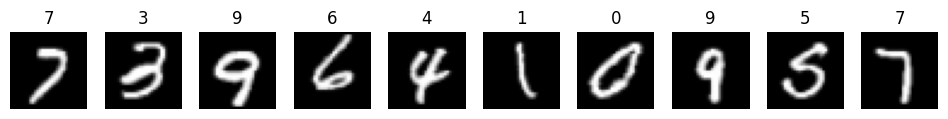

In [40]:
import matplotlib.pyplot as plt

labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

plt.figure(figsize=(12, 1))
cols, rows = 10, 1
for i in range(1, cols * rows + 1):
    idx = torch.randint(len(train_ds), size=(1,)).item()
    img, label = train_ds[idx]
    plt.subplot(rows, cols, i)
    plt.axis('off')
    plt.imshow(img.squeeze(), cmap='gray')
    plt.title(label)
plt.show()

### Training

In [41]:
from typing import Tuple, Dict
from tqdm.notebook import tqdm
from torch.utils.tensorboard import SummaryWriter
from torch.optim import Optimizer, Adam
from torchmetrics import Accuracy, Metric

In [42]:
def train(model: nn.Module,
          train_loader: DataLoader,
          loss_fn: nn.Module,
          accuracy_fn: Metric,
          optimizer: Optimizer,
          device: torch.device) -> Tuple[float, float]:

    model.train()
    train_loss, train_accuracy = 0.0, 0.0

    for X, y in train_loader:
        X, y = X.to(device), y.to(device)

        y_pred = model(X)

        loss = loss_fn(y_pred, y)
        train_loss += loss.item()
        train_accuracy += accuracy_fn(y_pred, y).item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return train_loss / len(train_loader), train_accuracy / len(train_loader)

In [43]:
def validate(model: nn.Module,
             valid_loader: DataLoader,
             loss_fn: nn.Module,
             accuracy_fn: Metric,
             device: torch.device) -> Tuple[float, float]:

    model.eval()
    valid_loss, valid_accuracy = 0.0, 0.0

    with torch.no_grad():
        for X, y in valid_loader:
            X, y = X.to(device), y.to(device)

            y_pred = model(X)
            valid_loss += loss_fn(y_pred, y).item()
            valid_accuracy += accuracy_fn(y_pred, y).item()

    return valid_loss / len(valid_loader), valid_accuracy / len(valid_loader)

In [44]:
model = LeNet5()
loss_fn = nn.CrossEntropyLoss()
accuracy_fn = Accuracy(task="multiclass", num_classes=10)
optimizer = Adam(params=model.parameters(), lr=0.001)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
accuracy_fn.to(device)

epochs = 15

losses = {'train': [], 'valid': []}
accuracies = {'train': [], 'valid': []}

for epoch in tqdm(range(epochs)):
    train_loss, train_accuracy = train(
        model,
        train_loader,
        loss_fn,
        accuracy_fn,
        optimizer,
        device
    )
    valid_loss, valid_accuracy = validate(
        model,
        valid_loader,
        loss_fn,
        accuracy_fn,
        device
    )

    print(f"\nEpoch: {epoch}\nTrain loss: {train_loss: .4f} | Train accuracy: {train_accuracy: .4f}")
    print(f"Valid loss: {valid_loss: .4f} | Valid accuracy: {valid_accuracy: .4f}")

    losses['train'].append(train_loss)
    losses['valid'].append(valid_loss)
    accuracies['train'].append(train_accuracy)
    accuracies['valid'].append(valid_accuracy)


  0%|          | 0/15 [00:00<?, ?it/s]


Epoch: 0
Train loss:  0.2497 | Train accuracy:  0.9246
Valid loss:  0.0945 | Valid accuracy:  0.9709

Epoch: 1
Train loss:  0.0670 | Train accuracy:  0.9796
Valid loss:  0.0506 | Valid accuracy:  0.9842

Epoch: 2
Train loss:  0.0470 | Train accuracy:  0.9854
Valid loss:  0.0443 | Valid accuracy:  0.9876

Epoch: 3
Train loss:  0.0376 | Train accuracy:  0.9882
Valid loss:  0.0457 | Valid accuracy:  0.9858

Epoch: 4
Train loss:  0.0314 | Train accuracy:  0.9897
Valid loss:  0.0391 | Valid accuracy:  0.9877

Epoch: 5
Train loss:  0.0261 | Train accuracy:  0.9914
Valid loss:  0.0378 | Valid accuracy:  0.9873

Epoch: 6
Train loss:  0.0211 | Train accuracy:  0.9934
Valid loss:  0.0392 | Valid accuracy:  0.9885

Epoch: 7
Train loss:  0.0199 | Train accuracy:  0.9936
Valid loss:  0.0371 | Valid accuracy:  0.9899

Epoch: 8
Train loss:  0.0172 | Train accuracy:  0.9942
Valid loss:  0.0473 | Valid accuracy:  0.9892

Epoch: 9
Train loss:  0.0149 | Train accuracy:  0.9952
Valid loss:  0.0388 | Vali

#### Plot training

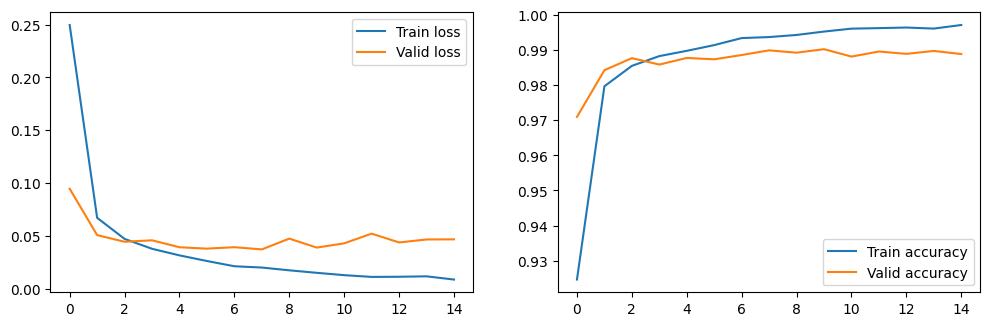

In [45]:
fig = plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(losses['train'], label='Train loss')
plt.plot(losses['valid'], label='Valid loss')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(accuracies['train'], label='Train accuracy')
plt.plot(accuracies['valid'], label='Valid accuracy')
plt.legend()

plt.show()

#### Save & load the model

In [46]:
from pathlib import Path

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME = "lenet5.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

torch.save(obj=model.state_dict(), f=MODEL_SAVE_PATH)

model_loaded = LeNet5()
model_loaded.load_state_dict(torch.load(f=MODEL_SAVE_PATH))
model_loaded.to(device)

LeNet5(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
  (relu3): ReLU()
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=120, out_features=84, bias=True)
    (2): ReLU()
    (3): Linear(in_features=84, out_features=10, bias=True)
  )
)

### Test

In [47]:
test_loss, test_accuracy = 0.0, 0.0

model_loaded.eval()
with torch.inference_mode():
    for X, y in test_loader:
        X, y = X.to(device), y.to(device)

        y_pred = model_loaded(X)

        test_loss += loss_fn(y_pred, y).item()
        test_accuracy += accuracy_fn(y_pred, y).item()

    test_loss /= len(test_loader)
    test_accuracy /= len(test_loader)

test_loss, test_accuracy

(0.0459784911771811, 0.990047770700637)

### Explainability

In [48]:
import numpy as np

from captum.attr import (
    IntegratedGradients,
    GuidedBackprop,
    Saliency,
    visualization as viz
)

import warnings
warnings.filterwarnings('ignore')

class ModelExplainer:
    def __init__(self, model: nn.Module, device: torch.device) -> None:
        self.model = model.eval()
        self.device = device
        self.integrated_gradients = IntegratedGradients(self.model)
        self.guided_backprop = GuidedBackprop(self.model)
        self.saliency = Saliency(self.model)

    def get_attributions(self, img: Tensor, label: int) -> Dict[str, np.ndarray]:
        input_img = img.unsqueeze(0).to(self.device)
        attributions = {}
        ig_attr = self.integrated_gradients.attribute(input_img, target=label)
        attributions['Integrated Gradients'] = ig_attr.cpu().detach().numpy()
        guided_attr = self.guided_backprop.attribute(input_img, target=label)
        attributions['Guided Backprop'] = guided_attr.cpu().detach().numpy()
        saliency_attr = self.saliency.attribute(input_img, target=label)
        attributions['Saliency'] = saliency_attr.cpu().detach().numpy()

        return attributions

    def visualize_all(self, img: Tensor, label: int) -> None:
        attributions = self.get_attributions(img, label)
        fig, axes = plt.subplots(1, 4, figsize=(16, 4))
        img_np = img.squeeze().cpu().numpy()
        axes[0].imshow(img_np, cmap='gray')
        axes[0].set_title(label)
        axes[0].axis('off')

        methods = [
            ('Integrated Gradients', 1),
            ('Saliency', 2),
            ('Guided Backprop', 3)
        ]

        for method_name, idx in methods:
            attr = attributions[method_name]
            attr = np.expand_dims(attr.squeeze(), axis=2)
            img_np_3d = np.expand_dims(img_np, axis=2)

            viz.visualize_image_attr(
                attr,
                img_np_3d,
                method='heat_map',
                sign='all',
                plt_fig_axis=(fig, axes[idx]),
                use_pyplot=False,
                show_colorbar=True
            )

            axes[idx].set_title(method_name)
            axes[idx].axis('off')

        plt.tight_layout()
        plt.show()

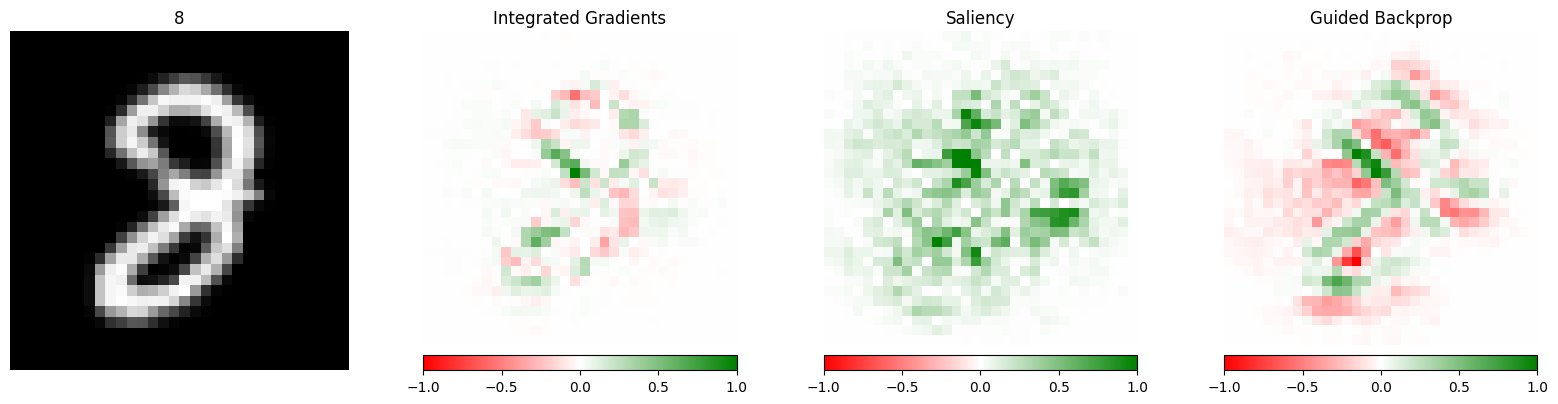

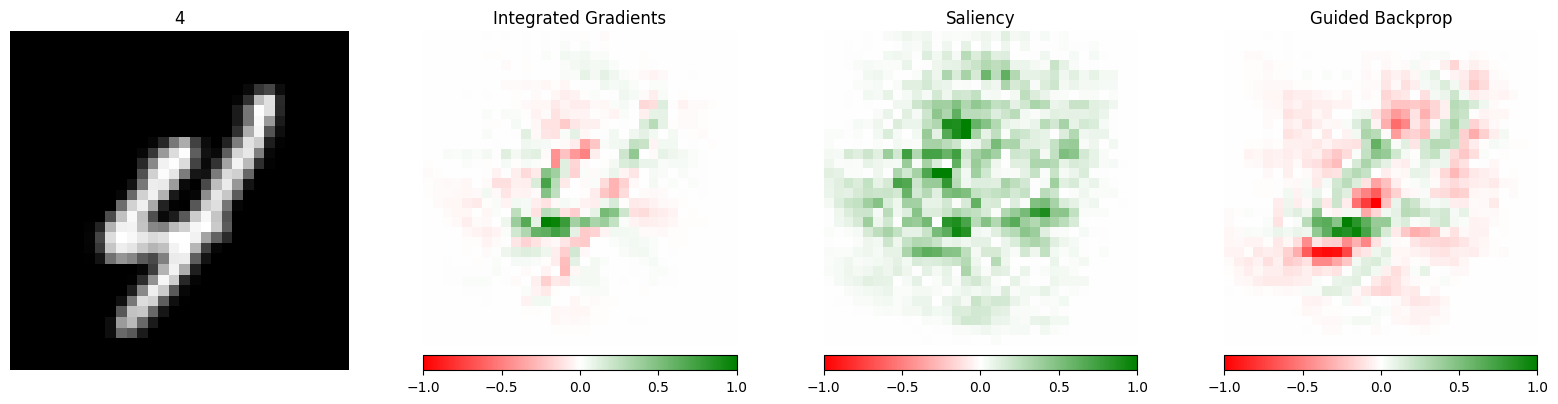

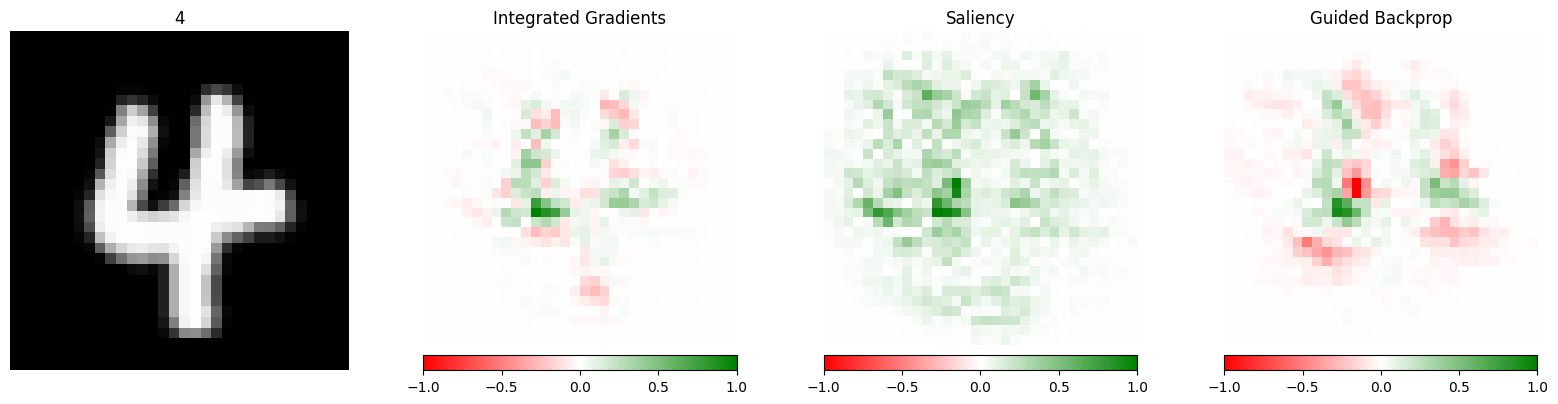

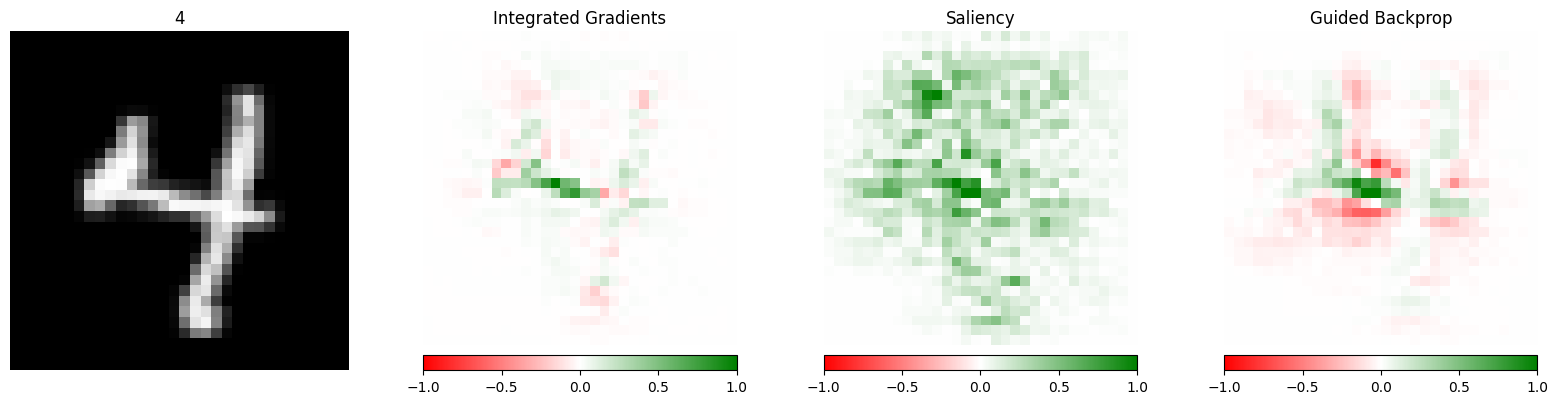

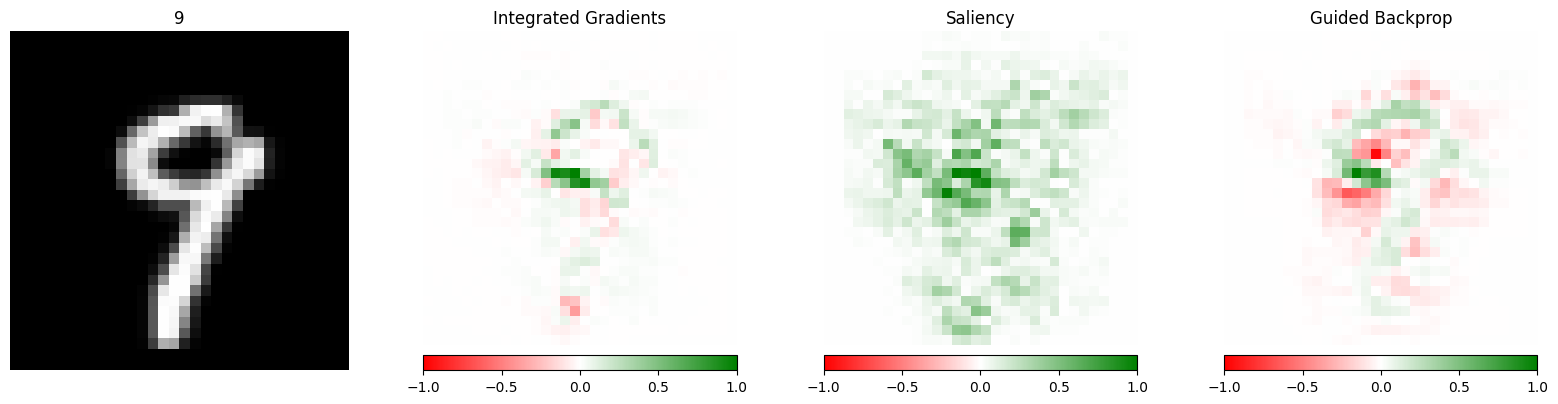

In [49]:
explainer = ModelExplainer(model_loaded, device)
torch.manual_seed(123)

for _ in range(5):
    idx = torch.randint(len(test_ds), size=(1,)).item()
    img, label = test_ds[idx]
    explainer.visualize_all(img, label)